In [1]:
%cd /autofs/cluster/fssubjects/test/mu40-crazy
%env CUDA_VISIBLE_DEVICES=0
!hostname
!nvidia-smi
!echo $PPID

/autofs/cluster/fssubjects/test/mu40-crazy
env: CUDA_VISIBLE_DEVICES=0
bal.nmr.mgh.harvard.edu
Wed Nov 22 21:06:30 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P4000                   On  | 00000000:03:00.0 Off |                  N/A |
| 46%   33C    P8               4W / 105W |     18MiB /  8192MiB |      0%      Default |
|                                         |                    

In [190]:
# External.
import pathlib
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display

# Internal.
import neurite as ne
import voxelmorph as vxm

In [3]:
# GPU setup.
tf.config.set_soft_device_placement(True)
for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

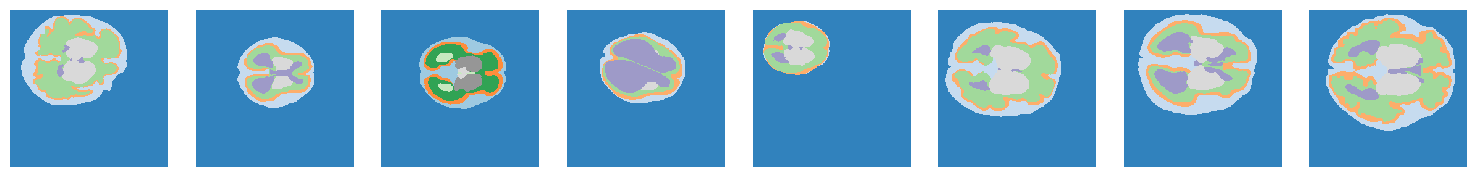

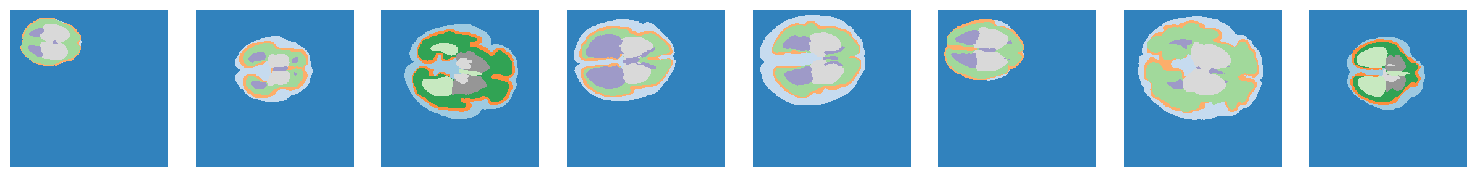

FeTA labels: 0 1 2 3 4 5 6 7


In [81]:
# FeTA data.
feta = pathlib.Path('/autofs/space/bal_004/users/jd1677/synthstrip/feta_2d')
files = list(feta.glob('sub-???/sub-???_dseg.nii.gz'))
label_maps = [np.uint8(f.dataobj) for f in map(nib.load, files)]
labels = np.unique(label_maps)
in_shape = label_maps[0].shape


# Show.
num_row = 2
per_row = 8
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(label_maps[i:i + per_row], cmaps=['tab20c'])

print('FeTA labels:', *labels)

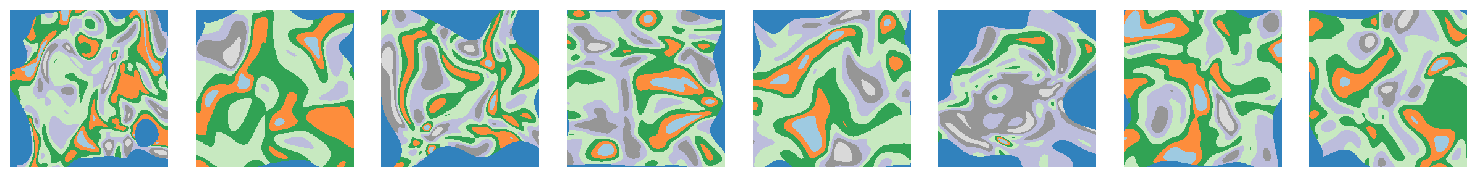

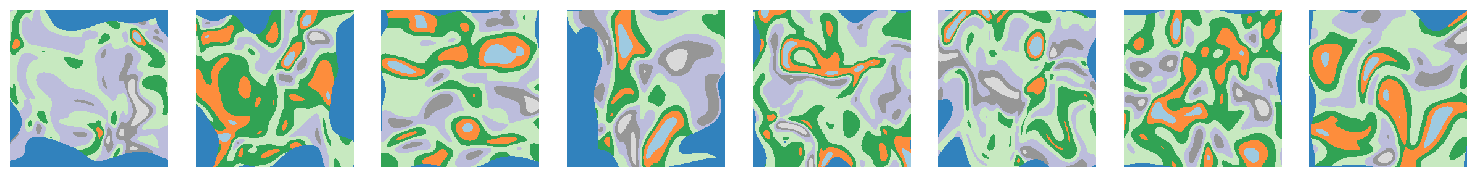

Shape labels: 8 9 10 11 12 13 14 15


In [83]:
# Random shapes.
def draw_shapes(
    shape,
    num_label=16,
    warp_min=1,
    warp_max=20,
    dtype=None,
    seed=None,
    image_fwhm_min=20,
    image_fwhm_max=40,
    warp_fwhm_min=40,
    warp_fwhm_max=80,
):
    # Data types.
    type_fp = tf.float16
    type_int = tf.int32
    if dtype is None:
        dtype = tf.keras.mixed_precision.global_policy().compute_dtype
    dtype = tf.dtypes.as_dtype(dtype)
    
    # Randomization.
    rand = np.random.default_rng(seed)
    seed = lambda: rand.integers(np.iinfo(np.int32).max, dtype=np.int32)
    prop = lambda: dict(isotropic=False, batched=False, featured=True, seed=seed(), dtype=type_fp, reduce=tf.math.reduce_max)
    
    # Images and transforms.
    v = ne.utils.augment.draw_perlin_full(
        shape=(*shape, 1),
        fwhm_min=image_fwhm_min, fwhm_max=image_fwhm_max, **prop(),
    )
    
    t = ne.utils.augment.draw_perlin_full(
        shape=(*shape, len(shape)), noise_min=warp_min, noise_max=warp_max,
        fwhm_min=warp_fwhm_min, fwhm_max=warp_fwhm_max, **prop(),
    )
    
    # Application and background.
    v = ne.utils.minmax_norm(v)
    v = vxm.utils.transform(v, t, fill_value=0)
    v = tf.math.ceil(v * (num_label - 1))

    return tf.cast(v, dtype) if v.dtype != dtype else v


# Generate.
num_labels = 8
num_shapes = 80
shapes = [draw_shapes(in_shape, num_labels) for _ in range(num_shapes)]
shapes = map(np.squeeze, shapes)
shapes = map(np.uint8, shapes)
shapes = [f + max(labels) + 1 for f in shapes]


# Show.
num_row = 2
per_row = 8
for i in range(0, num_row * per_row, per_row):
    ne.plot.slices(shapes[i:i + per_row], cmaps=['tab20c'])

print('Shape labels:', *np.unique(shapes))

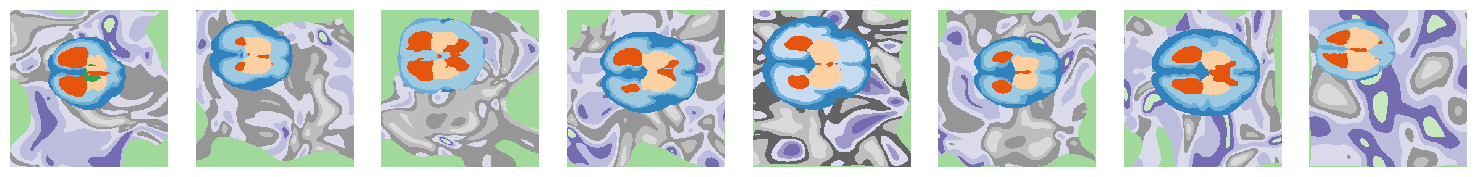

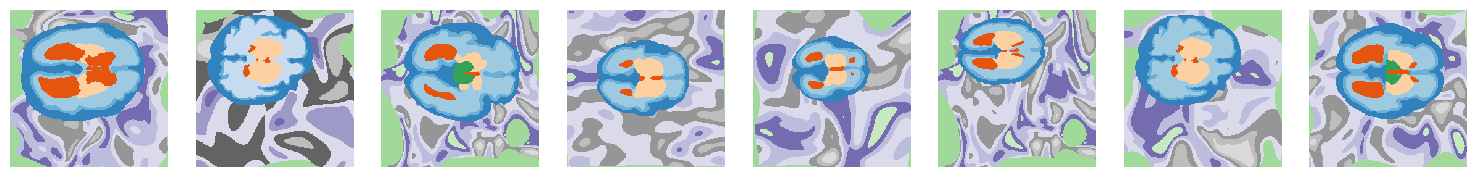

In [84]:
# Generator. This is just for a quick test and somewhat inefficient. Eventually,
# we'll want to generate shapes on the fly so that we are not limited to a finite
# number, augment these spatially using one labels-to-image instance, and combine
# these models with the image-synthesis and segmentation models into a single
# large network for optimization.

def generator(label_maps, shapes):
    rand = np.random.default_rng()
    label_maps = np.asarray(label_maps)
    shapes = np.asarray(shapes)
    
    while True:
        fg = rand.choice(label_maps)
        bg = rand.choice(shapes)
        out = fg + bg * (fg == 0)
        yield out[None, ..., None]


# Show.
gen = generator(label_maps, shapes)
num_row = 2
per_row = 8
for i in range(0, num_row * per_row, per_row):
    slices = [next(gen) for _ in range(per_row)]
    ne.plot.slices(slices, cmaps=['tab20c'])

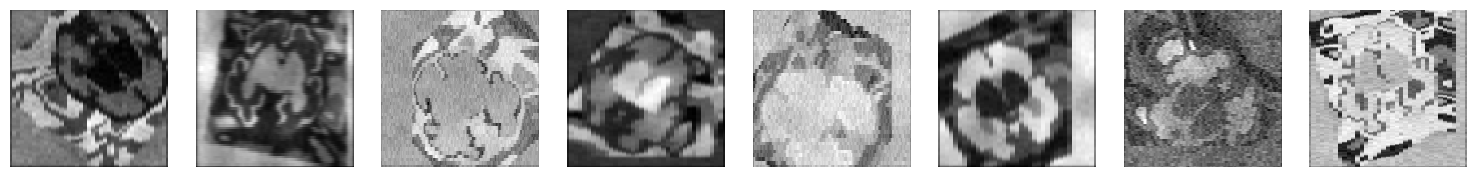

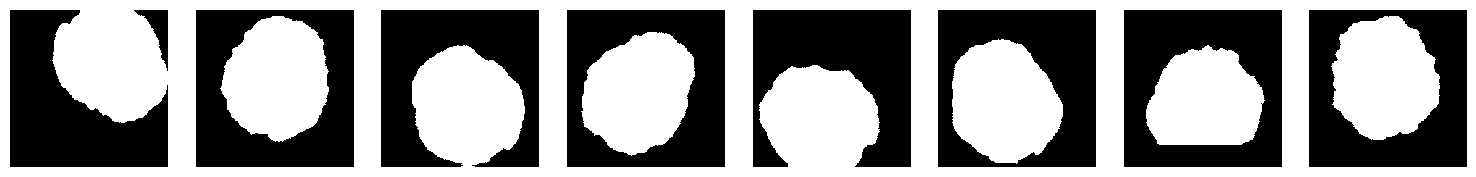

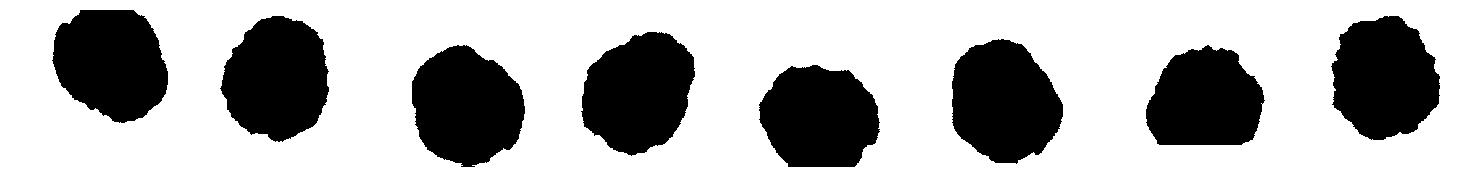

In [224]:
# Training-image generation. There is substantial brain-size variation in the FeTA
# data already, so let's not use scaling for now. Eventually, we may want to scale
# down only, so that the model learns how to deal with full-uterus scans. Real
# fetal MRI scans will likely not have a FOV smaller than the brain.
labels_in = range(max(labels) + num_labels + 1)

model_gen = ne.models.labels_to_image_new(
    in_shape=in_shape,
    labels_in=labels_in,
    labels_out={f: 1 if f in (1, 2, 3, 4, 5, 6, 7) else 2 for f in labels_in},
    aff_shift=30,
    aff_rotate=180,
    aff_shear=0.1,
    blur_max=3.4,
    slice_prob=1,
    crop_prob=1,
)


# Test repeatedly on the same input.
num_gen = 8
input = next(gen)
images, one_hot = zip(*[model_gen.predict(input, verbose=0) for _ in range(num_gen)])


# Example images and structures to align.
ne.plot.slices(images)
for i in range(one_hot[0].shape[-1]):
    ne.plot.slices([f[..., i] for f in one_hot]);

In [191]:
# Segmentation model.
features = [16 * 2 ** i for i in range(5)]
per_level = 2


# Features.
enc = sum(([f] * per_level for f in features), [])
dec = [*reversed(enc), 2]
features = (enc, dec)
print('Features:', features)


# Build.
model_seg = vxm.networks.Unet(
    inshape=(*in_shape, 1),
    nb_features=features,
    nb_conv_per_level=per_level,
    final_activation_function='softmax',
)
model_seg.summary()

Features: ([16, 16, 32, 32, 64, 64, 128, 128, 256, 256], [256, 256, 128, 128, 64, 64, 32, 32, 16, 16, 2])
Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 unet_input (InputLayer)     [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 unet_enc_conv_0_0 (Conv2D)  (None, 256, 256, 16)         160       ['unet_input[0][0]']          
                                                                                                  
 unet_enc_conv_0_0_activati  (None, 256, 256, 16)         0         ['unet_enc_conv_0_0[0][0]']   
 on (LeakyReLU)                                                                                   
                                                                                        

In [195]:
# Combined model: synthesis and segmentation.
ima, true = model_gen.outputs
pred = model_seg(ima)
model = tf.keras.Model(inputs=model_gen.inputs, outputs=pred)


# Apparently, a proper soft-Dice loss squares the summands in the denominator.
def soft_dice(a, b):
    dim = len(a.shape) - 2
    space = list(range(1, dim + 1))

    top = 2 * tf.reduce_sum(a * b, axis=space)
    bot = tf.reduce_sum(a ** 2, axis=space) + tf.reduce_sum(b ** 2, axis=space)
    
    out = tf.divide(top, bot + 1e-6)
    return -tf.reduce_mean(out)


# Compile for training.
model.add_loss(soft_dice(true, pred))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

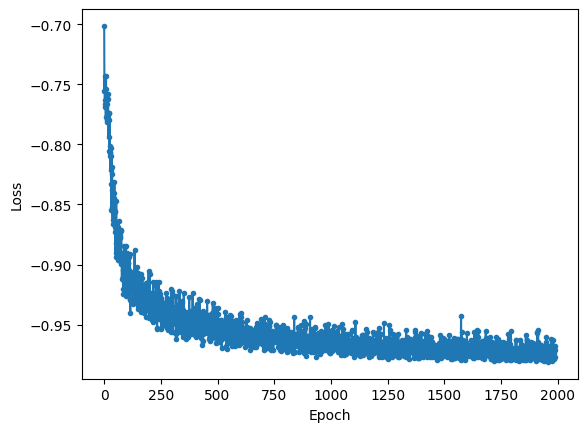

Epoch 1991/2000
100/100 [==============================] - 5s 47ms/step - loss: -0.9670
Epoch 1992/2000
100/100 [==============================] - 4s 45ms/step - loss: -0.9737
Epoch 1993/2000
100/100 [==============================] - 4s 44ms/step - loss: -0.9721
Epoch 1994/2000
100/100 [==============================] - 4s 43ms/step - loss: -0.9740
Epoch 1995/2000
100/100 [==============================] - 4s 43ms/step - loss: -0.9731
Epoch 1996/2000
100/100 [==============================] - 4s 44ms/step - loss: -0.9719
Epoch 1997/2000
100/100 [==============================] - 4s 43ms/step - loss: -0.9670
Epoch 1998/2000
100/100 [==============================] - 4s 44ms/step - loss: -0.9707
Epoch 1999/2000
100/100 [==============================] - 4s 44ms/step - loss: -0.9744
Epoch 2000/2000
100/100 [==============================] - 5s 45ms/step - loss: -0.9790


In [228]:
# Training. Re-running cell will continue training.
reset = 0
epochs = 10
repeat = 200


# Initialize.
if reset or 'log_epoch' not in locals():
    log_epoch = []
    log_loss = []


for _ in range(repeat):
    IPython.display.clear_output(wait=True)
    if log_epoch:
        plt.plot(log_epoch, log_loss, '.-')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        
    init = log_epoch[-1] + 1 if log_epoch else 0
    hist = model.fit(gen, initial_epoch=init, epochs=epochs + init, steps_per_epoch=100)
    log_epoch.extend(hist.epoch)
    log_loss.extend(hist.history['loss'])

Input:


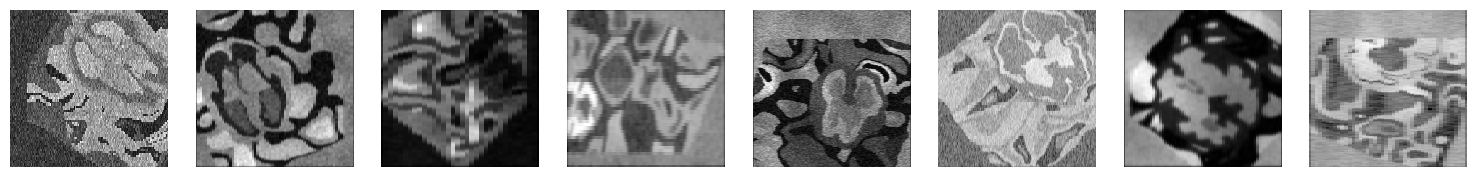

Prediction:


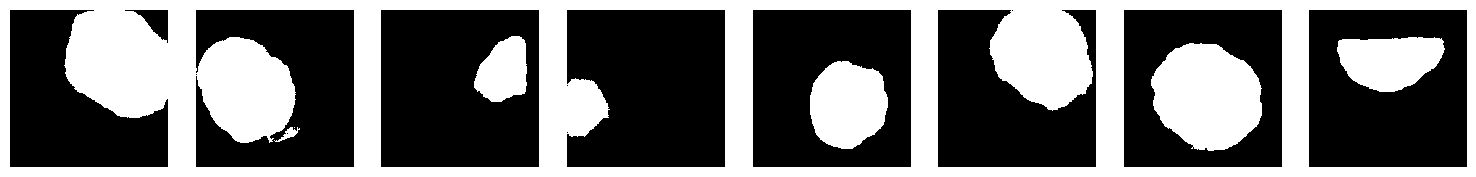

Ground truth:


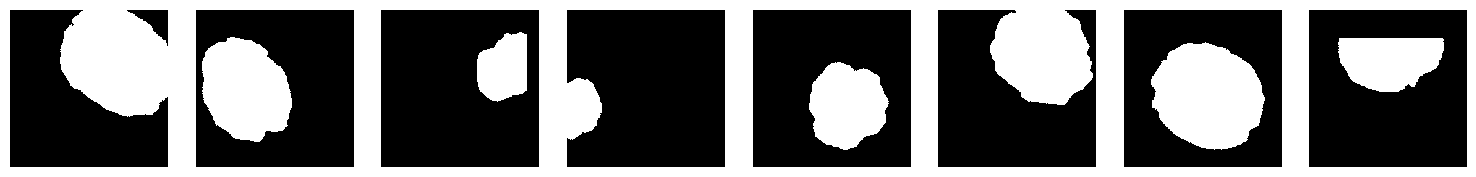

Difference:


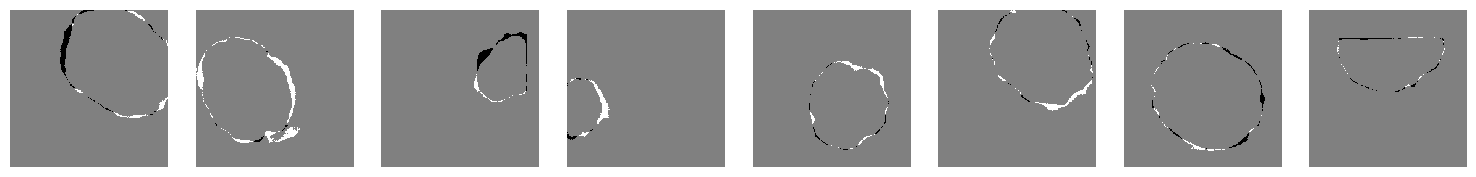

In [234]:
# Test on training data.
num_test = 8


# Predict.
imag, true = zip(*[model_gen.predict(next(gen), verbose=0) for _ in range(num_test)])
pred = [model_seg.predict(i, verbose=0) for i in imag]
pred = [np.argmax(p[..., ::-1], axis=-1) for p in pred]
true = [np.argmax(t[..., ::-1], axis=-1) for t in true]


# Plot.
print('Input:')
ne.plot.slices(imag)

print('Prediction:')
ne.plot.slices(pred)

print('Ground truth:')
ne.plot.slices(true)

print('Difference:')
ne.plot.slices([p - t for p, t in zip(pred, true)]);